In [6130]:
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

from PIL import Image
import os

In [6131]:
class ImagesDataset(Dataset):
    
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.img_names = os.listdir(root_dir)
        self.data_transforms = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ToTensor()])
        
    def __getitem__(self, index):
        img = Image.open(self.root_dir + '/' + self.img_names[index]).convert('L')
        item = self.data_transforms(img)
        img.close()
        min = item.min()
        max = item.max()
        if min != max:
            item = (item - min) / (max - min)
        return item.view(1, 64, 64)

    def __len__(self):
        return len(self.img_names)

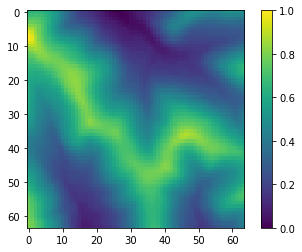

In [6132]:
import matplotlib.pyplot as plt

dataset = ImagesDataset('./data')
p = plt.imshow(dataset[6498].view(64, 64))
plt.colorbar(p)
plt.show()

In [6133]:
batch_size = 100
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [8988]:
def double_cnn(in_n, out_n):
    return nn.Sequential(
        nn.Conv2d(in_n, out_n, kernel_size=3, padding=1),
        nn.LeakyReLU(),
        nn.Conv2d(out_n, out_n, kernel_size=3, padding=1)
    )

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        # Encoder specification
        self.enc_cnn_1 = double_cnn(1, 32)
        self.enc_cnn_2 = double_cnn(32, 64)
        self.enc_cnn_3 = double_cnn(64, 128)
        self.enc_cnn_4 = double_cnn(128, 256)
        
        self.enc_linear_1_1 = nn.Linear(4096, 64)
        self.enc_linear_1_2 = nn.Linear(4096, 64)
        
        # Decoder specification
        self.dec_linear_1 = nn.Linear(64, 4096)
        
        self.dec_cnn_1 = double_cnn(256, 128)
        self.dec_cnn_2 = double_cnn(128, 64)
        self.dec_cnn_3 = double_cnn(64, 32)
        self.dec_cnn_4 = double_cnn(32, 1)
        
    def encode(self, data):
        x = self.enc_cnn_1(data)
        x = F.leaky_relu(F.max_pool2d(x, 2))

        x = self.enc_cnn_2(x)
        x = F.leaky_relu(F.max_pool2d(x, 2))

        x = self.enc_cnn_3(x)
        x = F.leaky_relu(F.max_pool2d(x, 2))

        x = self.enc_cnn_4(x)
        x = F.leaky_relu(F.max_pool2d(x, 2))

        x = x.view(x.size(0), -1)
        return self.enc_linear_1_1(x), self.enc_linear_1_2(x)
    
    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.cuda.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)
        
    def decode(self, z):
        out = F.leaky_relu(self.dec_linear_1(z))
        out = out.view(out.size(0), 256, 4, 4)
        
        out = F.interpolate(out, 8)
        out = F.leaky_relu(self.dec_cnn_1(out))
        
        out = F.interpolate(out, 16)
        out = F.leaky_relu(self.dec_cnn_2(out))
        
        out = F.interpolate(out, 32)
        out = F.leaky_relu(self.dec_cnn_3(out))
        
        out = F.interpolate(out, 64)
        out = torch.sigmoid(self.dec_cnn_4(out))
        
        return out
        
    def forward(self, data):
        mu, logvar = self.encode(data)
        z = self.reparametrize(mu, logvar)
        out = self.decode(z)
        return out, mu, logvar

In [8999]:
vae = VAE().cuda()

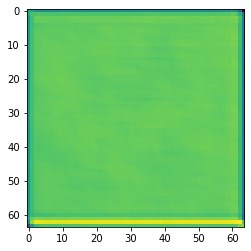

In [9000]:
x = dataset[400].cuda()
out, _, _ = vae(x.view(1, 1, 64, 64))
plt.imshow(out.view(64, 64).cpu().detach().numpy())
plt.show()

In [9001]:
import torch.optim as optim

def loss_function(recon_x, x, mu, logvar):
    MSE = nn.MSELoss(reduction='sum')(recon_x, x)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    KLD *= 0.1
    return MSE + KLD, MSE, KLD

optimizer = optim.Adam(vae.parameters(), lr=0.0001)

epochs = 100

for epoch in range(epochs):
    vae.train()
    i = 0
    for data in dataloader:
        i += 1
        optimizer.zero_grad()
        x = data.cuda()
        out, mu, logvar = vae(x)
        loss, MSE, KLD = loss_function(out, x, mu, logvar)
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            msg = "epoch[{}/{}], loss={:.3f}, MSE={:.3f}, KLD={:.3f}".format(epoch + 1, epochs, 
                  loss.item() / batch_size, MSE.item() / batch_size, KLD.item() / batch_size)
            print(msg)

epoch[1/100], loss=151.717, MSE=148.333, KLD=3.384
epoch[1/100], loss=128.336, MSE=123.465, KLD=4.871
epoch[1/100], loss=61.481, MSE=54.921, KLD=6.560
epoch[1/100], loss=56.108, MSE=48.831, KLD=7.278
epoch[1/100], loss=50.798, MSE=43.556, KLD=7.242
epoch[2/100], loss=41.680, MSE=34.747, KLD=6.933
epoch[2/100], loss=40.706, MSE=33.789, KLD=6.917
epoch[2/100], loss=40.135, MSE=33.131, KLD=7.004
epoch[2/100], loss=37.362, MSE=30.680, KLD=6.682
epoch[2/100], loss=38.205, MSE=31.431, KLD=6.774
epoch[3/100], loss=31.765, MSE=25.149, KLD=6.616
epoch[3/100], loss=34.175, MSE=27.305, KLD=6.870
epoch[3/100], loss=34.520, MSE=27.793, KLD=6.728
epoch[3/100], loss=33.684, MSE=26.947, KLD=6.737
epoch[3/100], loss=33.000, MSE=26.372, KLD=6.629
epoch[4/100], loss=29.729, MSE=22.835, KLD=6.894
epoch[4/100], loss=30.806, MSE=24.282, KLD=6.524
epoch[4/100], loss=29.437, MSE=22.941, KLD=6.496
epoch[4/100], loss=30.305, MSE=23.696, KLD=6.609
epoch[4/100], loss=30.065, MSE=23.719, KLD=6.346
epoch[5/100], lo

epoch[34/100], loss=18.928, MSE=12.640, KLD=6.289
epoch[34/100], loss=17.975, MSE=11.554, KLD=6.421
epoch[34/100], loss=17.597, MSE=11.291, KLD=6.306
epoch[34/100], loss=17.446, MSE=11.150, KLD=6.296
epoch[34/100], loss=17.160, MSE=10.900, KLD=6.260
epoch[35/100], loss=17.776, MSE=11.420, KLD=6.355
epoch[35/100], loss=19.428, MSE=13.014, KLD=6.413
epoch[35/100], loss=16.885, MSE=10.631, KLD=6.253
epoch[35/100], loss=19.491, MSE=12.898, KLD=6.593
epoch[35/100], loss=16.950, MSE=10.659, KLD=6.291
epoch[36/100], loss=17.989, MSE=11.523, KLD=6.467
epoch[36/100], loss=18.671, MSE=12.315, KLD=6.356
epoch[36/100], loss=18.117, MSE=11.682, KLD=6.435
epoch[36/100], loss=18.780, MSE=12.079, KLD=6.701
epoch[36/100], loss=20.020, MSE=13.317, KLD=6.703
epoch[37/100], loss=18.930, MSE=12.321, KLD=6.609
epoch[37/100], loss=18.544, MSE=12.120, KLD=6.424
epoch[37/100], loss=18.047, MSE=11.485, KLD=6.562
epoch[37/100], loss=17.462, MSE=11.174, KLD=6.288
epoch[37/100], loss=18.548, MSE=11.943, KLD=6.604


epoch[67/100], loss=17.125, MSE=10.586, KLD=6.539
epoch[67/100], loss=15.981, MSE=9.483, KLD=6.498
epoch[67/100], loss=18.376, MSE=11.415, KLD=6.960
epoch[67/100], loss=17.191, MSE=10.393, KLD=6.798
epoch[67/100], loss=17.396, MSE=10.390, KLD=7.006
epoch[68/100], loss=15.825, MSE=9.547, KLD=6.279
epoch[68/100], loss=16.063, MSE=9.580, KLD=6.484
epoch[68/100], loss=17.792, MSE=11.178, KLD=6.614
epoch[68/100], loss=16.480, MSE=9.735, KLD=6.745
epoch[68/100], loss=15.794, MSE=9.298, KLD=6.496
epoch[69/100], loss=16.302, MSE=9.452, KLD=6.850
epoch[69/100], loss=16.979, MSE=10.106, KLD=6.873
epoch[69/100], loss=17.602, MSE=10.747, KLD=6.855
epoch[69/100], loss=16.388, MSE=9.762, KLD=6.626
epoch[69/100], loss=15.537, MSE=9.101, KLD=6.436
epoch[70/100], loss=15.504, MSE=9.012, KLD=6.492
epoch[70/100], loss=16.792, MSE=10.167, KLD=6.625
epoch[70/100], loss=16.906, MSE=10.229, KLD=6.677
epoch[70/100], loss=15.907, MSE=9.523, KLD=6.384
epoch[70/100], loss=16.869, MSE=10.294, KLD=6.575
epoch[71/1

epoch[100/100], loss=16.213, MSE=9.630, KLD=6.583
epoch[100/100], loss=17.206, MSE=10.274, KLD=6.932
epoch[100/100], loss=16.131, MSE=9.685, KLD=6.446
epoch[100/100], loss=16.829, MSE=10.013, KLD=6.817


In [9002]:
torch.cuda.empty_cache()

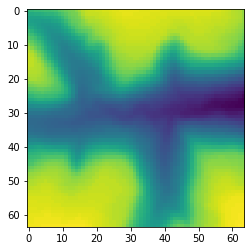

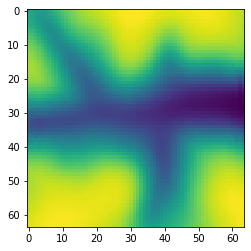

In [9004]:
x = dataset[5948].cuda()
plt.imshow(x.view(64, 64).cpu())
plt.show()
out, _, _ = vae(x.view(1, 1, 64, 64))
plt.imshow(out.view(64, 64).cpu().detach().numpy())
plt.show()

In [8732]:
#torch.save(vae.state_dict(), './vae_save')

In [7295]:
vae.load_state_dict(torch.load('./vae_save'))

<All keys matched successfully>

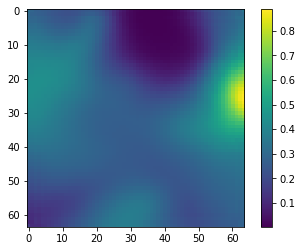

In [9091]:
# Generator
code = torch.FloatTensor(1, 64).normal_()

out = vae.decode(code.cuda())
p = plt.imshow(out.view(64, 64).cpu().detach().numpy())
plt.colorbar(p)
plt.show()